In [84]:
from global_config import config
import pandas as pd
import numpy as np
import rpy2
import os

from datetime import date, timedelta


data_dir_mnps   = config.get_property('geo_dir')
data_dir        = config.get_property('data_dir')
fb_ppl_data     = config.get_property('covid_fb')
results_dir     = config.get_property('results_dir')
data_cases_path = os.path.join(fb_ppl_data, 'agglomerated', 'geometry')

In [85]:
def crosscorr(series1, series2, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return series2.corr(series1.shift(lag))


def compute_correlation(series2, series1, lags = list(range(10)), start_day='01-04-2020', final_day=None):

    if not start_day:
        start_day = min(series1.index.values[0], series2.index.values[0])
    if not final_day:
        final_day = min(series1.index.values[-1], series2.index.values[-1])

    min_date = pd.to_datetime(start_day, dayfirst=True)
    max_date = pd.to_datetime(final_day, dayfirst=True)

    series1 = series1.loc[start_day:max_date]
    series2 = series2.loc[start_day:max_date]

    corr_df = pd.DataFrame(columns = ['lag', 'value'])
    corr_df['lag'] = lags
    corr_df = corr_df.set_index('lag')

    for idx, lag in enumerate(lags):
        corr_df.loc[ lag ]['value'] = crosscorr(series1, series2, lag=lag)

    return corr_df

In [86]:
rt_df = pd.read_csv( os.path.join(results_dir, 'bog_rt', 'rt_df_bog_confirmation.csv') )
rt_df = rt_df[rt_df["variable"]=='R']
rt_df['date'] = rt_df['date'].map(lambda x: pd.to_datetime(0)+timedelta(days=x))


cases_df = pd.read_csv(os.path.join(data_cases_path, 'cases.csv'), parse_dates=["date_time"])

In [140]:
PR_2020_df     = pd.read_csv(os.path.join(data_dir,  'pagerank_ciudades2_2020.csv'), sep=',', parse_dates=['date'])
PR_2020_df["correct"] = False
PR_2020_df = PR_2020_df.set_index(['date','attribute_name', 'correct'] )



PR_2021_df     = pd.read_csv(os.path.join(data_dir,  'pagerank_ciudades2.csv'), sep=',', parse_dates=['date'])#.set_index(['date','attribute_name'] )
PR_2021_df["correct"] = False
PR_2021_df = PR_2021_df.set_index(['date','attribute_name', 'correct'] )


pr_df = pd.concat([PR_2020_df, PR_2021_df]).reset_index()
pr_df.to_csv(os.path.join(data_dir,  'pagerang_merged.csv'))
pr_df

,date,attribute_name,correct,location_id,attribute_value,type
0,2020-02-09,pagerank_gini_index,False,colombia_bogota,0.496280,city
1,2020-02-10,pagerank_gini_index,False,colombia_bogota,0.495470,city
2,2020-02-11,pagerank_gini_index,False,colombia_bogota,0.492339,city
3,2020-02-12,pagerank_gini_index,False,colombia_bogota,0.492152,city
4,2020-02-13,pagerank_gini_index,False,colombia_bogota,0.493053,city
...,...,...,...,...,...,...
746,2021-04-13,personalized_pagerank_gini_index,False,colombia_bogota,0.542777,city
747,2021-04-16,personalized_pagerank_gini_index,False,colombia_bogota,0.543110,city
748,2021-04-19,personalized_pagerank_gini_index,False,colombia_bogota,0.430362,city
749,2021-04-22,personalized_pagerank_gini_index,False,colombia_bogota,0.426548,city


In [114]:
ppr_bog_df = pr_df[pr_df["attribute_name"]=="personalized_pagerank_gini_index"]
pr_bog_df  = pr_df[pr_df["attribute_name"]=="pagerank_gini_index"]

ppr_bog_df = ppr_bog_df.set_index('date') #
ppr_bog_df = ppr_bog_df[["attribute_value"]].resample('1D').mean()#.interpolate(method='polynomial', order=2)
ppr_bog_df = ppr_bog_df.interpolate(method='linear', order=2)
ppr_bog_df = ppr_bog_df.reset_index()

pr_bog_df = pr_bog_df.set_index('date') #
pr_bog_df = pr_bog_df[["attribute_value"]].resample('1D').mean()#.interpolate(method='polynomial', order=2)
pr_bog_df = pr_bog_df.interpolate(method='linear', order=2)
pr_bog_df = pr_bog_df.reset_index()


In [115]:
rt_df = pd.read_csv( os.path.join(results_dir, 'bog_rt', 'rt_df_{}_confirmation.csv'.format('bog')))
rt_df = rt_df[rt_df["variable"]=="R"]
rt_df['date'] = rt_df['date'].map(lambda x: pd.to_datetime(0)+timedelta(days=x))


In [116]:

from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import seaborn as sns




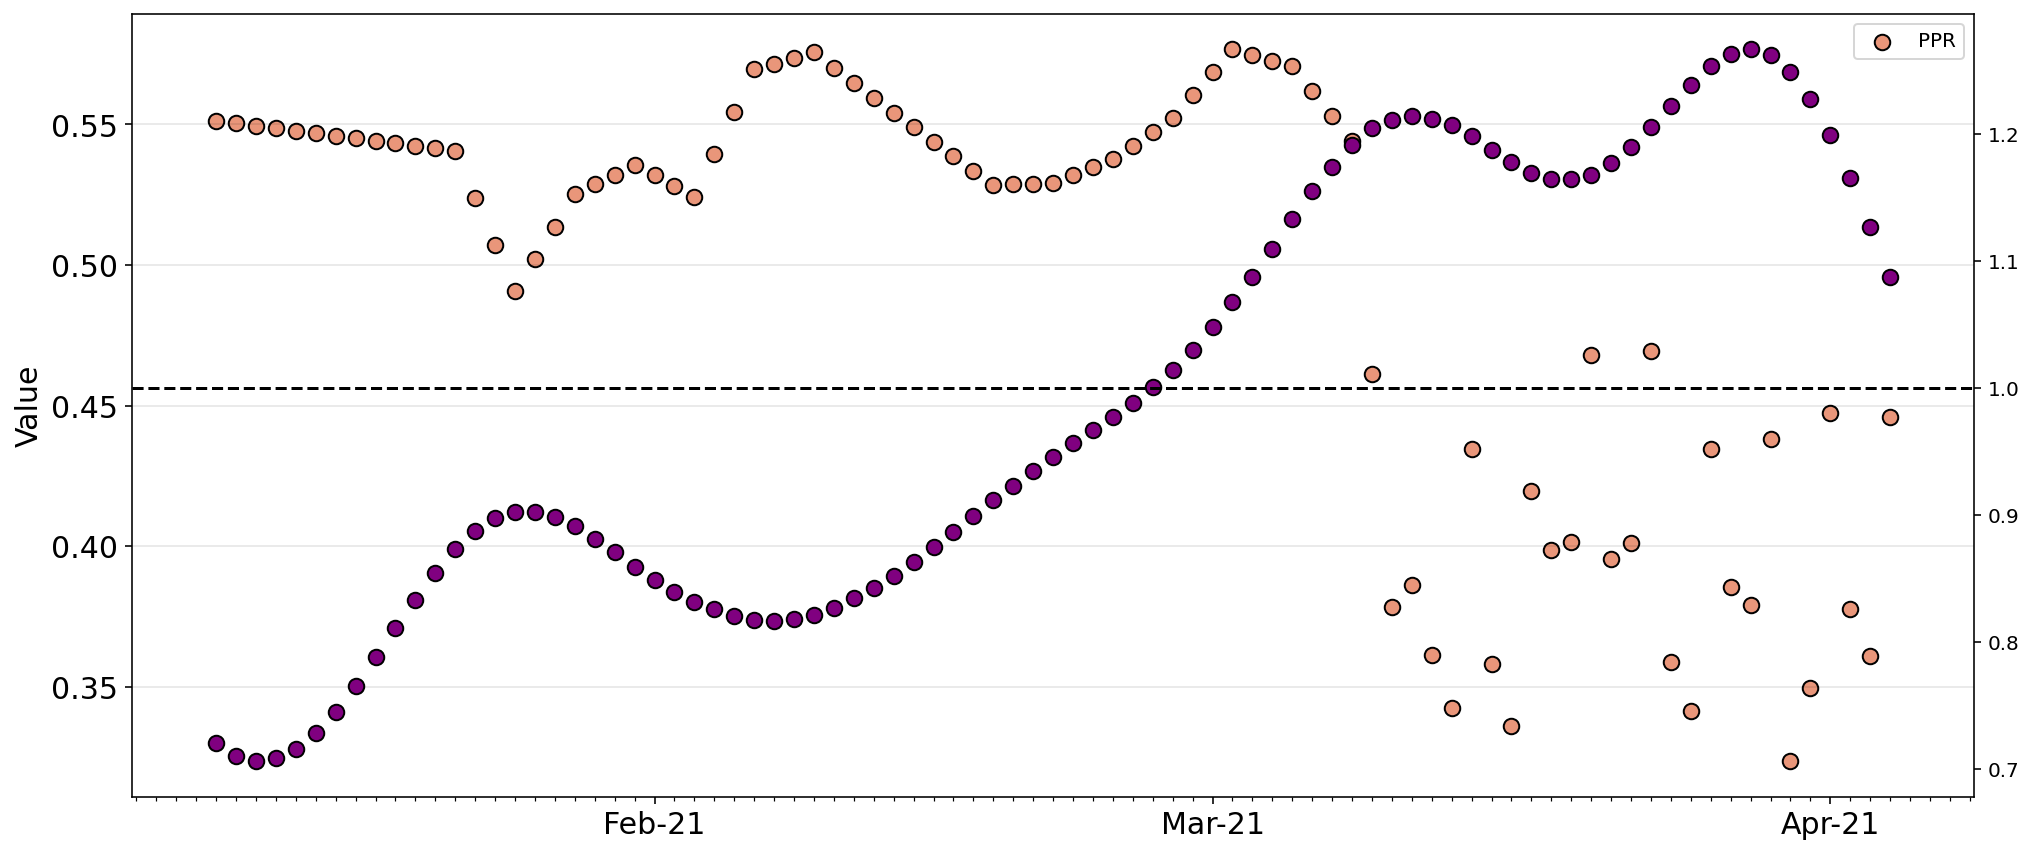

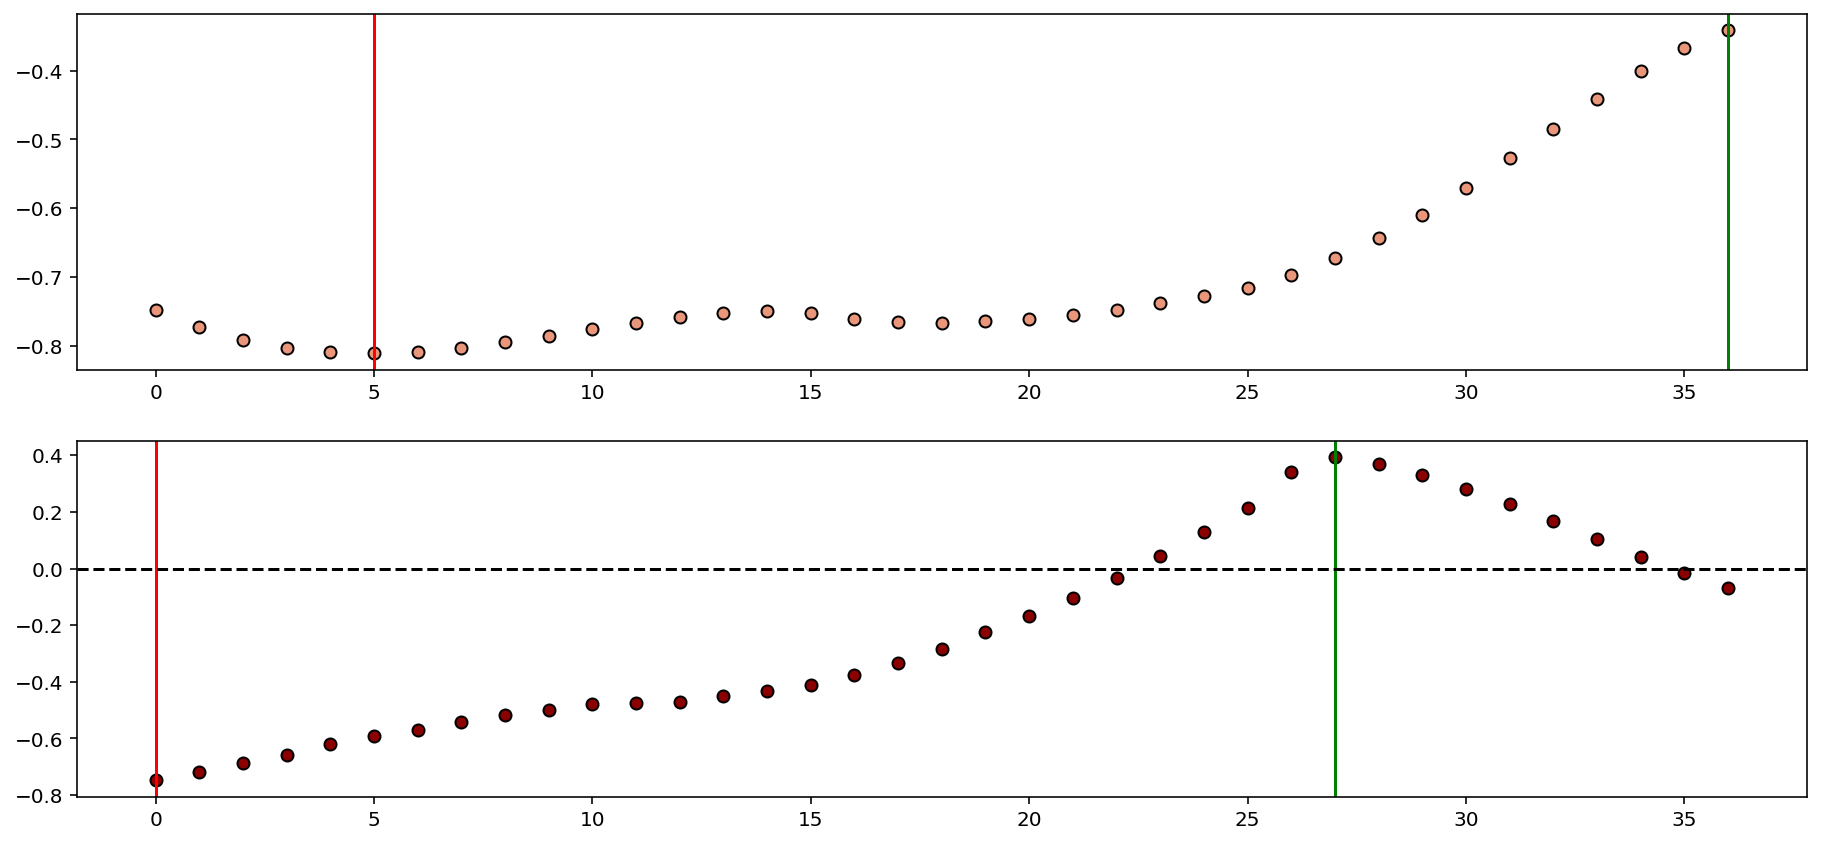

In [142]:
df_all = pd.merge( ppr_bog_df.set_index('date'),  rt_df.set_index("date"), left_index=True, right_index=True)
df_all = df_all[df_all["type"]=="estimate"]
df_all = df_all[["attribute_value", "median"]]
df_all = df_all.reset_index()

df_all = df_all.set_index("date")
df_all = df_all.loc[pd.to_datetime("2021-01-10"):]
df_all = df_all.reset_index()

fig, ax = plt.subplots(1, 1, figsize=(16.5, 7.2))
ax.scatter(df_all["date"], df_all["attribute_value"], facecolor='darksalmon', edgecolor='k', s=60, label='PPR')
ax1 = ax.twinx()
ax1.scatter(df_all["date"], df_all["median"], facecolor='purple', edgecolor='k', s=60, label='Rt')
ax1.axhline(y=1, color='k', linestyle='--')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator())

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.tick_params(axis='both', labelsize=15)
ax.set_ylabel('Value', fontsize=15)
ax.legend()

df_all = df_all.set_index('date')
corr_df1 = compute_correlation(df_all["attribute_value"], df_all["median"], lags = list(range(37) ) )
corr_df2 = compute_correlation(df_all["median"], df_all["attribute_value"], lags = list(range(37) ) )

fig, ax = plt.subplots(2,1, figsize=(15.5, 7.2))
ax[0].scatter(corr_df1.index.values, corr_df1["value"], edgecolor='k', facecolor='darksalmon')
ax[0].axvline(x=np.argmax(corr_df1["value"]), color='green' )
ax[0].axvline(x=np.argmin(corr_df1["value"]), color='red' )

ax[1].scatter(corr_df2.index.values, corr_df2["value"], edgecolor='k', facecolor='darkred')
ax[1].axvline(x=np.argmax(corr_df2["value"]), color='green' )
ax[1].axvline(x=np.argmin(corr_df2["value"]), color='red' )
ax[1].axhline(y=0, color='k', linestyle='--')


/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


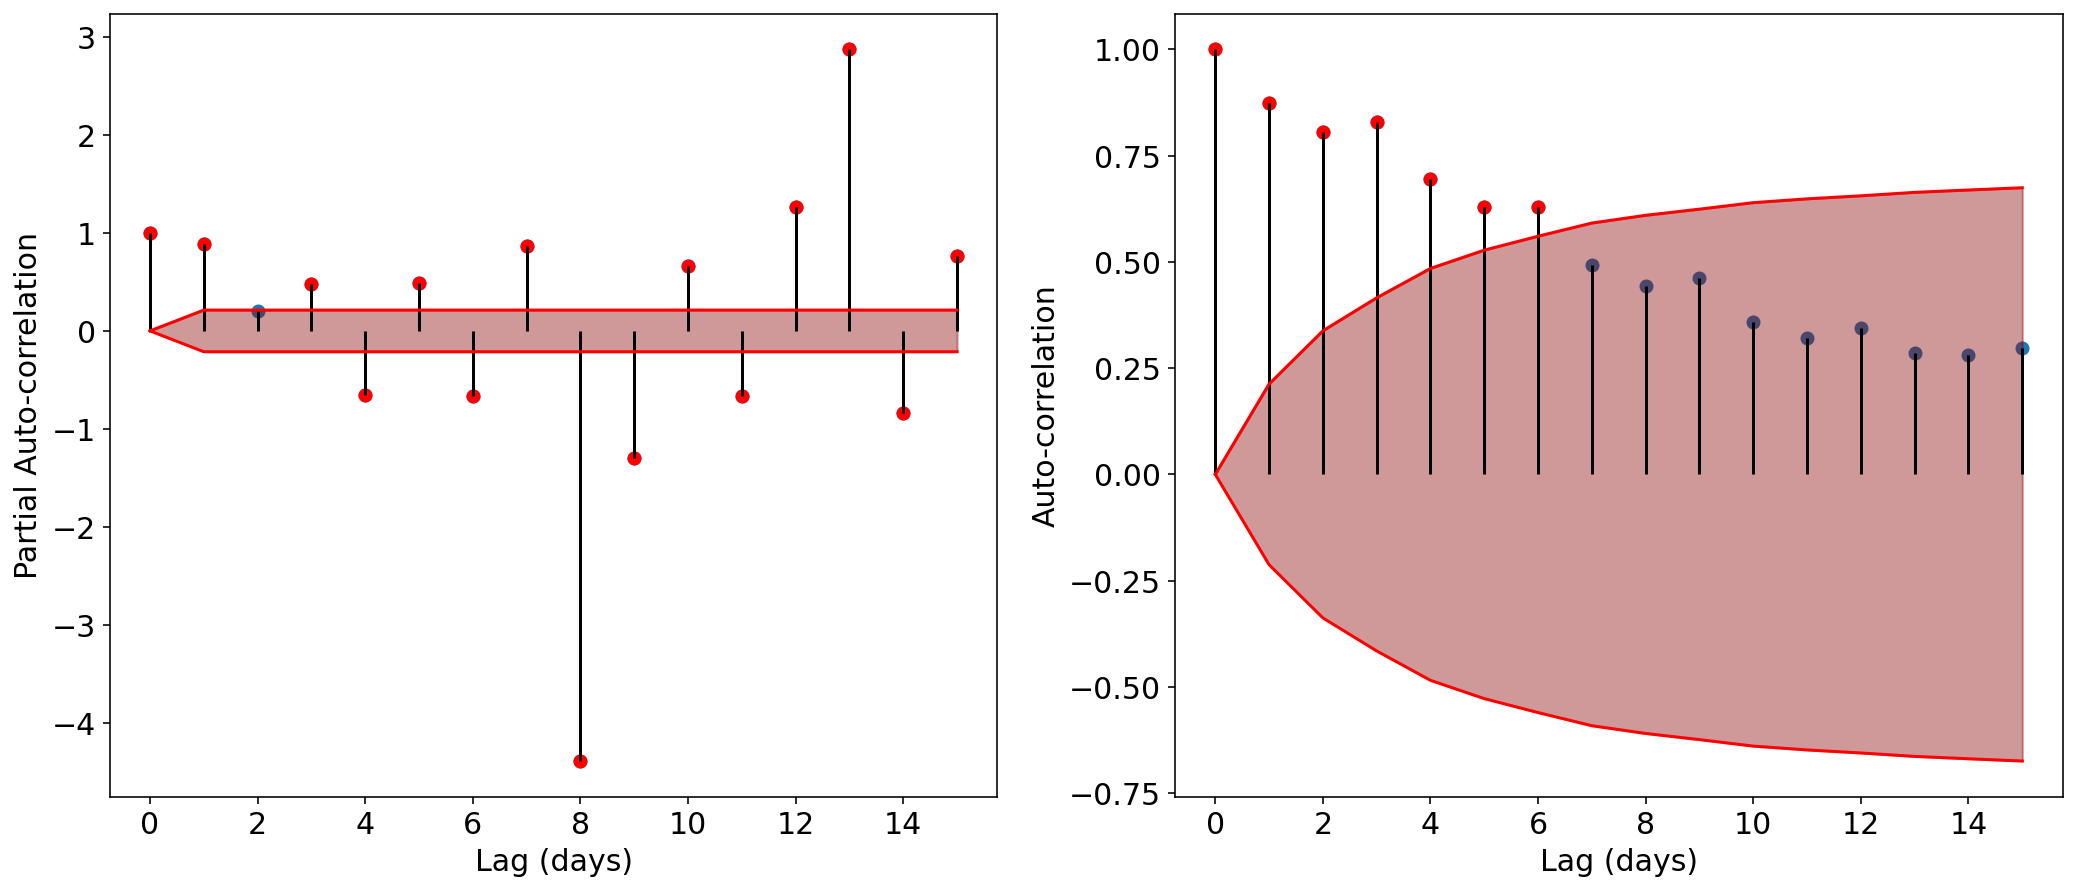

In [131]:
from statsmodels.tsa.stattools import acf, pacf

nlags = 15

a = acf(df_all["attribute_value"], nlags=nlags, alpha=0.05)
idx_keep = (a[0]<= a[1][:,0]-a[0]) + (a[0]>= a[1][:,1]-a[0])

fig, ax = plt.subplots(1, 2, figsize=(17.5, 7.2))

ax[1].scatter(range(nlags+1), a[0],)
ax[1].scatter(np.where(idx_keep)[0], a[0][idx_keep], color='red')
ax[1].vlines(range(nlags+1), [0], a[0], color='k' )
ax[1].fill_between(range(nlags+1), a[1][:,0]-a[0], a[1][:,1]-a[0], color='darkred', alpha=0.4)
ax[1].plot(range(nlags+1), a[1][:,0]-a[0], color='red')
ax[1].plot(range(nlags+1), a[1][:,1]-a[0], color='red')
ax[1].set_xlabel('Lag (days)', fontsize=15)
ax[1].set_ylabel('Auto-correlation', fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)

a = pacf(df_all["attribute_value"], nlags=nlags, alpha=0.05)
idx_keep = (a[0]<= a[1][:,0]-a[0]) + (a[0]>= a[1][:,1]-a[0])
ax[0].scatter(range(nlags+1), a[0],)
ax[0].scatter(np.where(idx_keep)[0], a[0][idx_keep], color='red')
ax[0].vlines(range(nlags+1), [0], a[0], color='k' )
ax[0].fill_between(range(nlags+1), a[1][:,0]-a[0], a[1][:,1]-a[0], color='darkred', alpha=0.4)
ax[0].plot(range(nlags+1), a[1][:,0]-a[0], color='red')
ax[0].plot(range(nlags+1), a[1][:,1]-a[0], color='red')
ax[0].set_xlabel('Lag (days)', fontsize=15)
ax[0].set_ylabel('Partial Auto-correlation', fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
plt.show()

# PR

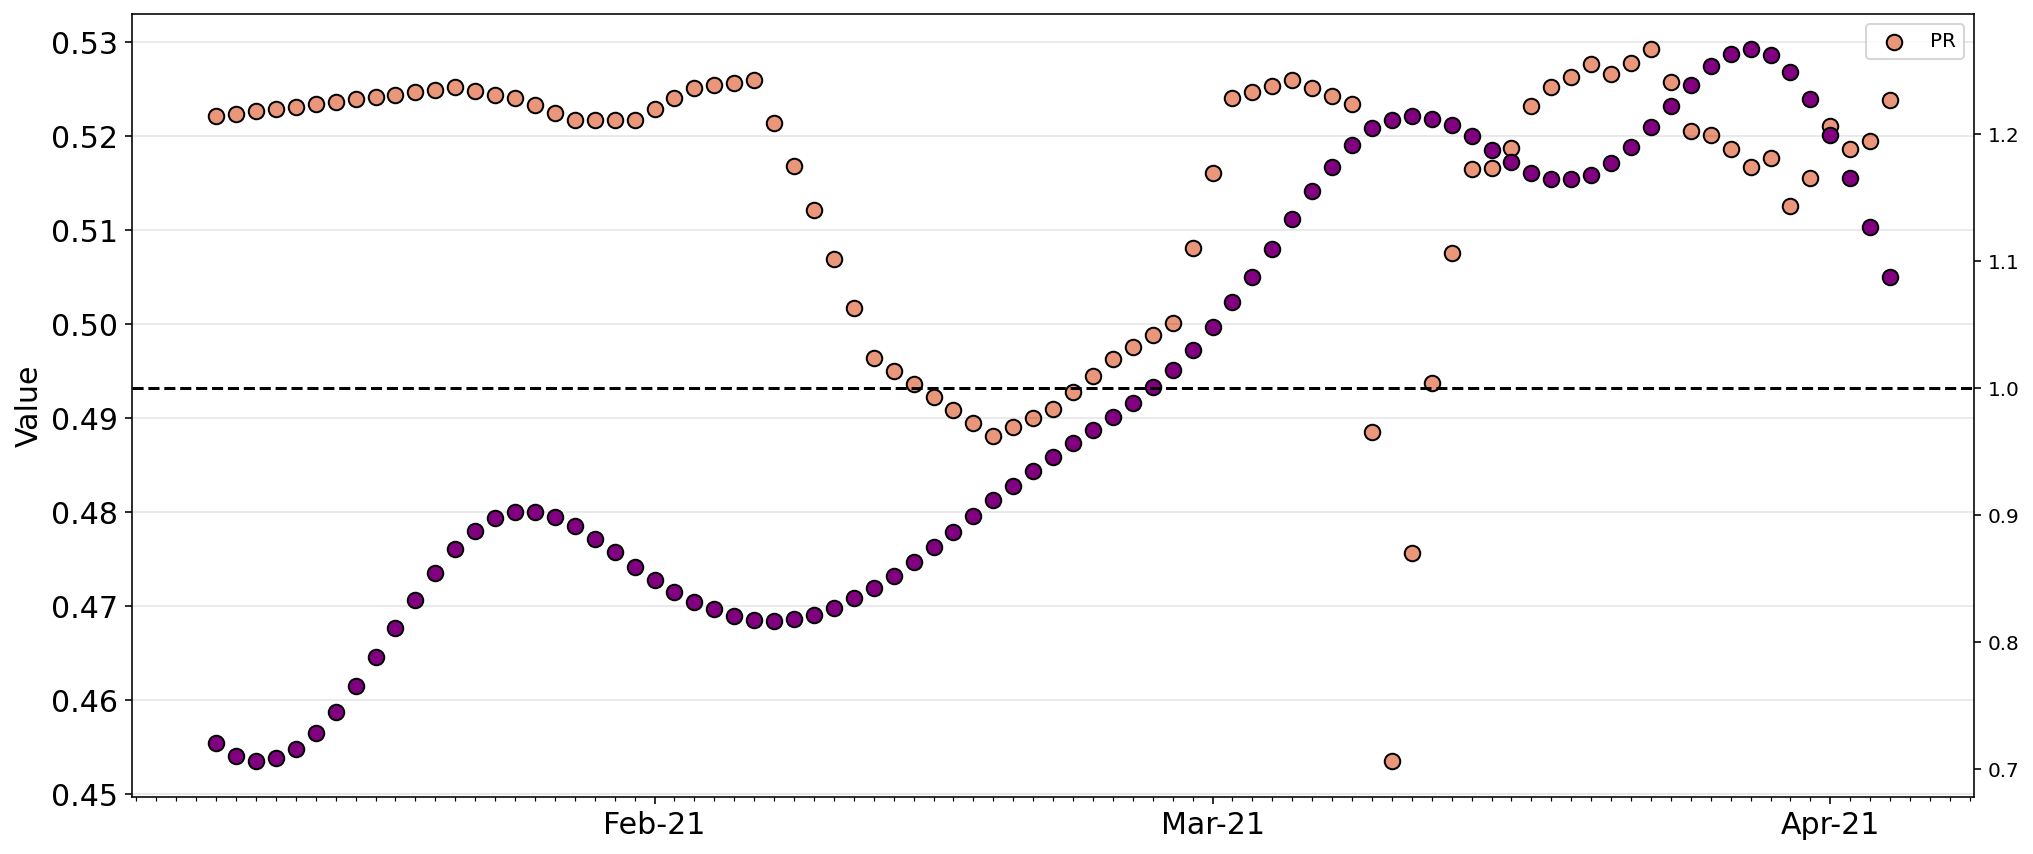

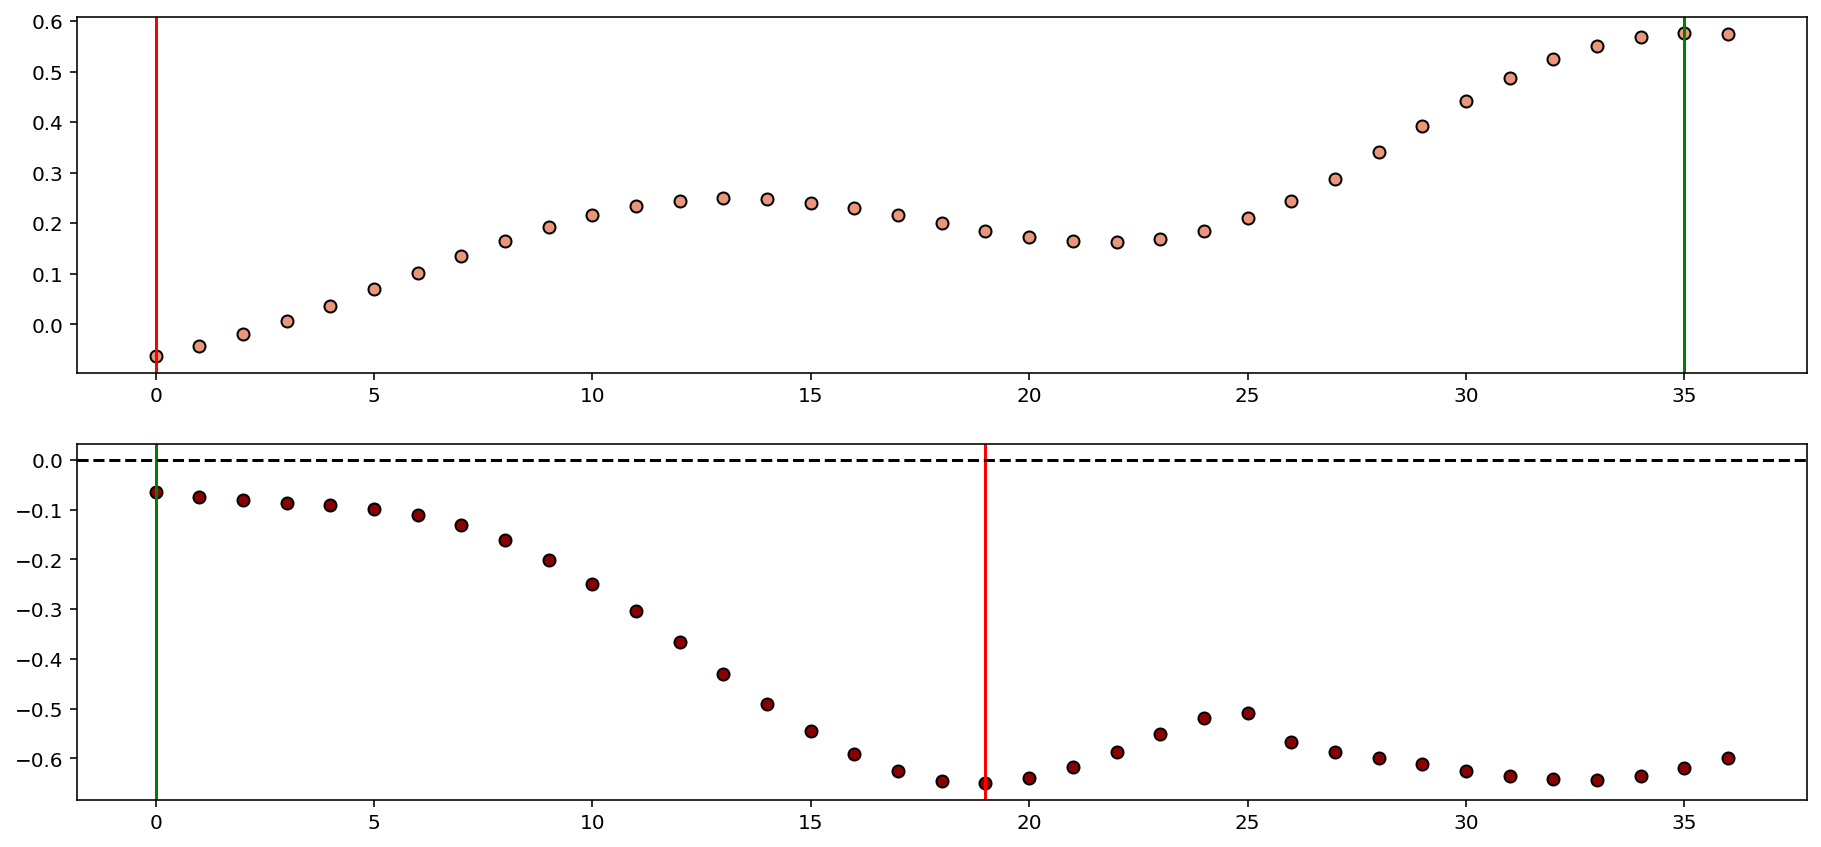

In [132]:
df_all = pd.merge( pr_bog_df.set_index('date'),  rt_df.set_index("date"), left_index=True, right_index=True)

df_all = df_all[df_all["type"]=="estimate"]
df_all = df_all[["attribute_value", "median"]]
df_all = df_all.reset_index()

df_all = df_all.set_index("date")
df_all = df_all.loc[pd.to_datetime("2021-01-10"):]
df_all = df_all.reset_index()



fig, ax = plt.subplots(1, 1, figsize=(16.5, 7.2))
ax.scatter(df_all["date"], df_all["attribute_value"], facecolor='darksalmon', edgecolor='k', s=60, label='PR')
ax1 = ax.twinx()
ax1.scatter(df_all["date"], df_all["median"], facecolor='purple', edgecolor='k', s=60, label='Rt')
ax1.axhline(y=1, color='k', linestyle='--')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator())

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.tick_params(axis='both', labelsize=15)
ax.set_ylabel('Value', fontsize=15)
ax.legend()

df_all = df_all.set_index('date')
corr_df1 = compute_correlation(df_all["attribute_value"], df_all["median"], lags = list(range(37) ) )
corr_df2 = compute_correlation(df_all["median"], df_all["attribute_value"], lags = list(range(37) ) )

fig, ax = plt.subplots(2,1, figsize=(15.5, 7.2))
ax[0].scatter(corr_df1.index.values, corr_df1["value"], edgecolor='k', facecolor='darksalmon')
ax[0].axvline(x=np.argmax(corr_df1["value"]), color='green' )
ax[0].axvline(x=np.argmin(corr_df1["value"]), color='red' )

ax[1].scatter(corr_df2.index.values, corr_df2["value"], edgecolor='k', facecolor='darkred')
ax[1].axvline(x=np.argmax(corr_df2["value"]), color='green' )
ax[1].axvline(x=np.argmin(corr_df2["value"]), color='red' )
ax[1].axhline(y=0, color='k', linestyle='--')


/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


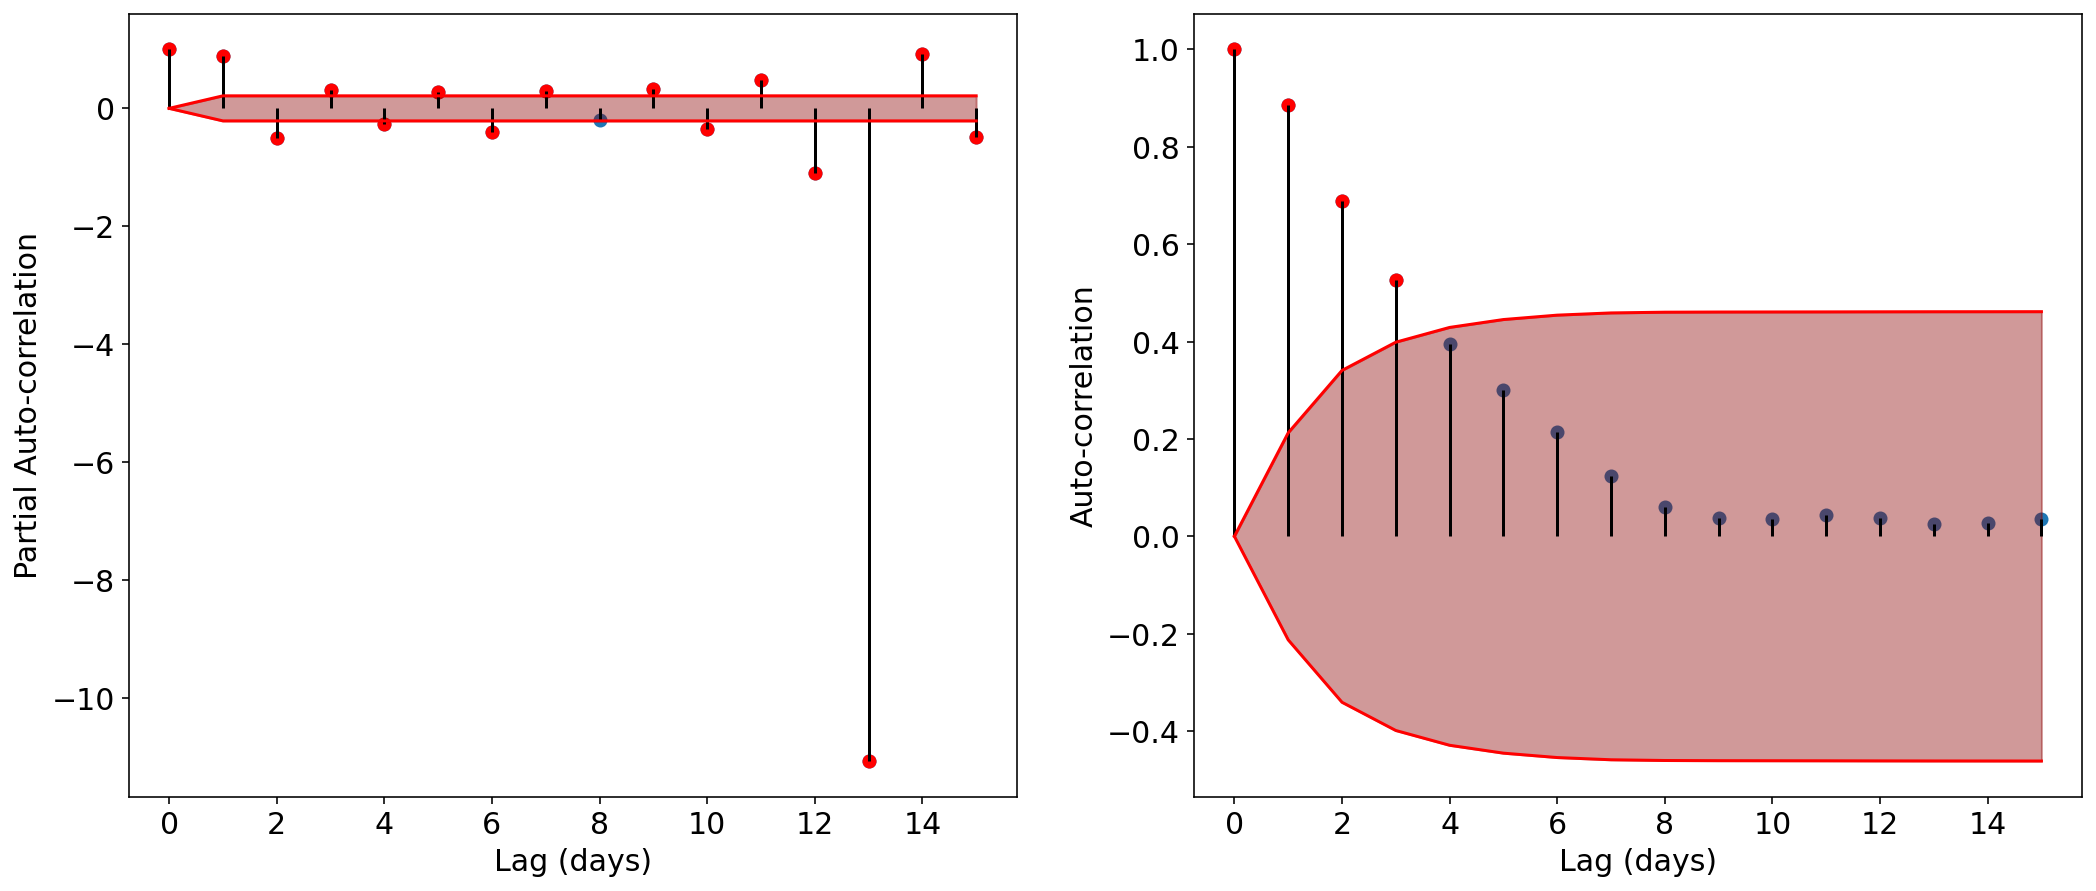

In [133]:
from statsmodels.tsa.stattools import acf, pacf

nlags = 15

a = acf(df_all["attribute_value"], nlags=nlags, alpha=0.05)
idx_keep = (a[0]<= a[1][:,0]-a[0]) + (a[0]>= a[1][:,1]-a[0])

fig, ax = plt.subplots(1, 2, figsize=(17.5, 7.2))

ax[1].scatter(range(nlags+1), a[0],)
ax[1].scatter(np.where(idx_keep)[0], a[0][idx_keep], color='red')
ax[1].vlines(range(nlags+1), [0], a[0], color='k' )
ax[1].fill_between(range(nlags+1), a[1][:,0]-a[0], a[1][:,1]-a[0], color='darkred', alpha=0.4)
ax[1].plot(range(nlags+1), a[1][:,0]-a[0], color='red')
ax[1].plot(range(nlags+1), a[1][:,1]-a[0], color='red')
ax[1].set_xlabel('Lag (days)', fontsize=15)
ax[1].set_ylabel('Auto-correlation', fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)

a = pacf(df_all["attribute_value"], nlags=nlags, alpha=0.05)
idx_keep = (a[0]<= a[1][:,0]-a[0]) + (a[0]>= a[1][:,1]-a[0])
ax[0].scatter(range(nlags+1), a[0],)
ax[0].scatter(np.where(idx_keep)[0], a[0][idx_keep], color='red')
ax[0].vlines(range(nlags+1), [0], a[0], color='k' )
ax[0].fill_between(range(nlags+1), a[1][:,0]-a[0], a[1][:,1]-a[0], color='darkred', alpha=0.4)
ax[0].plot(range(nlags+1), a[1][:,0]-a[0], color='red')
ax[0].plot(range(nlags+1), a[1][:,1]-a[0], color='red')
ax[0].set_xlabel('Lag (days)', fontsize=15)
ax[0].set_ylabel('Partial Auto-correlation', fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
plt.show()

In [134]:

ppr_bog_df["attribute_value2"] = 1/ppr_bog_df["attribute_value"]


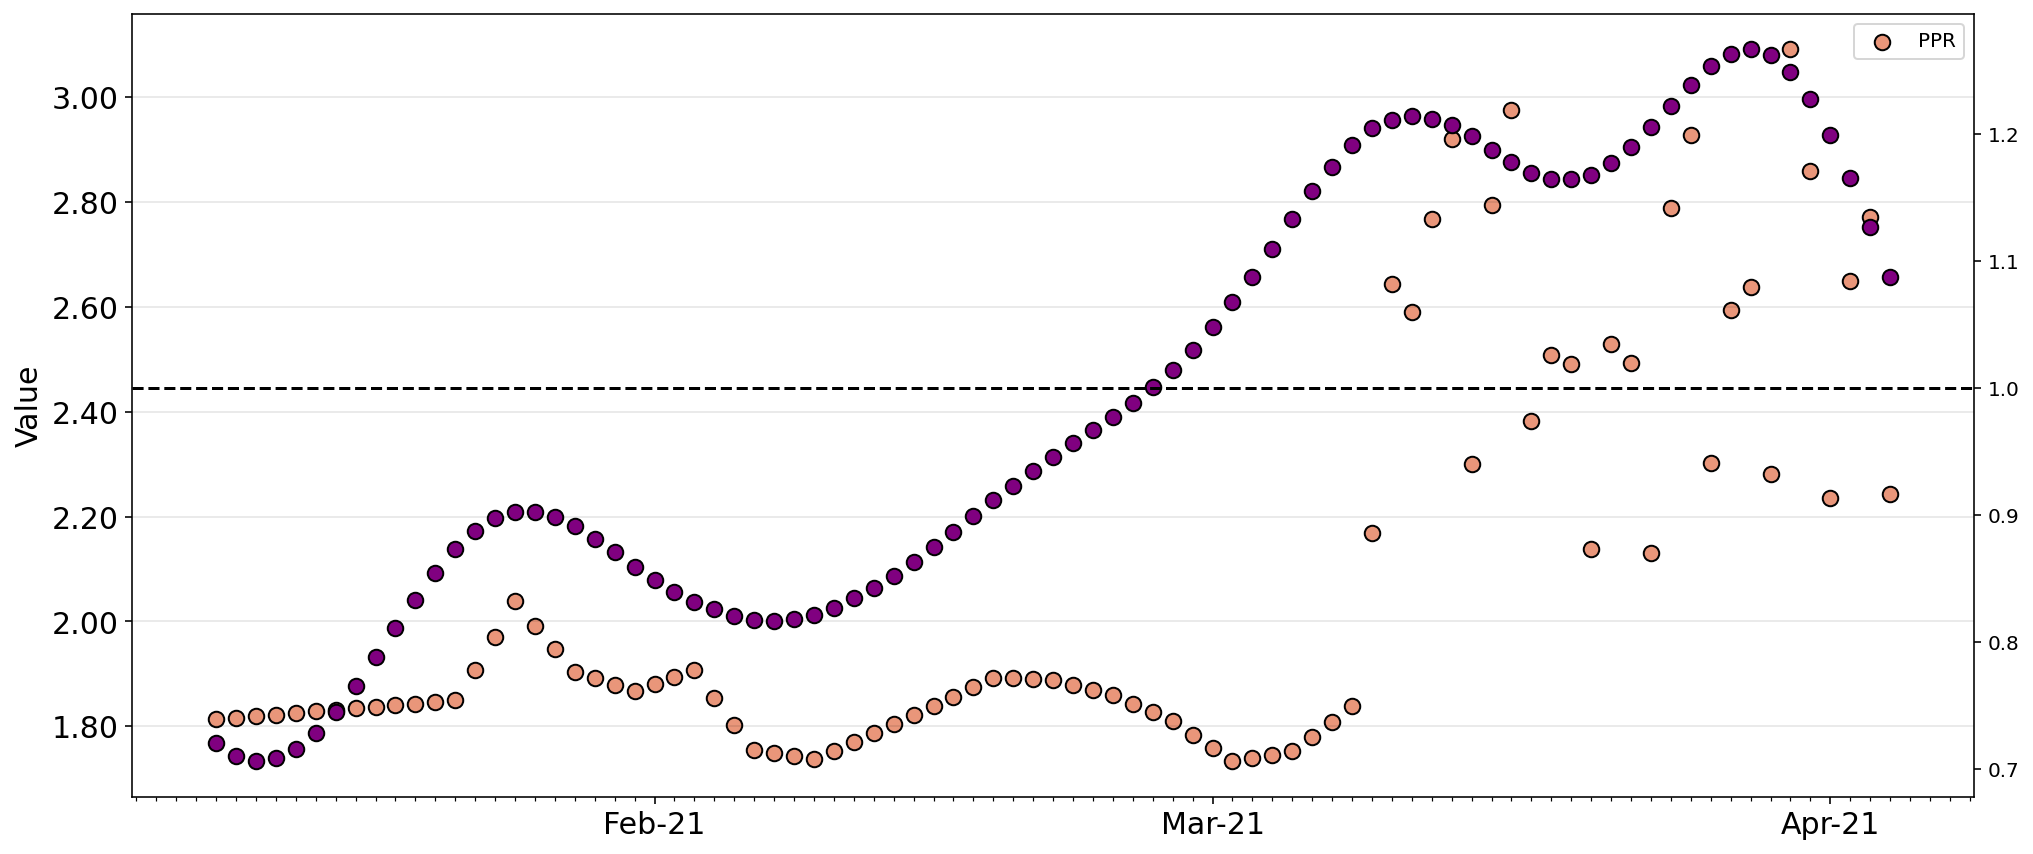

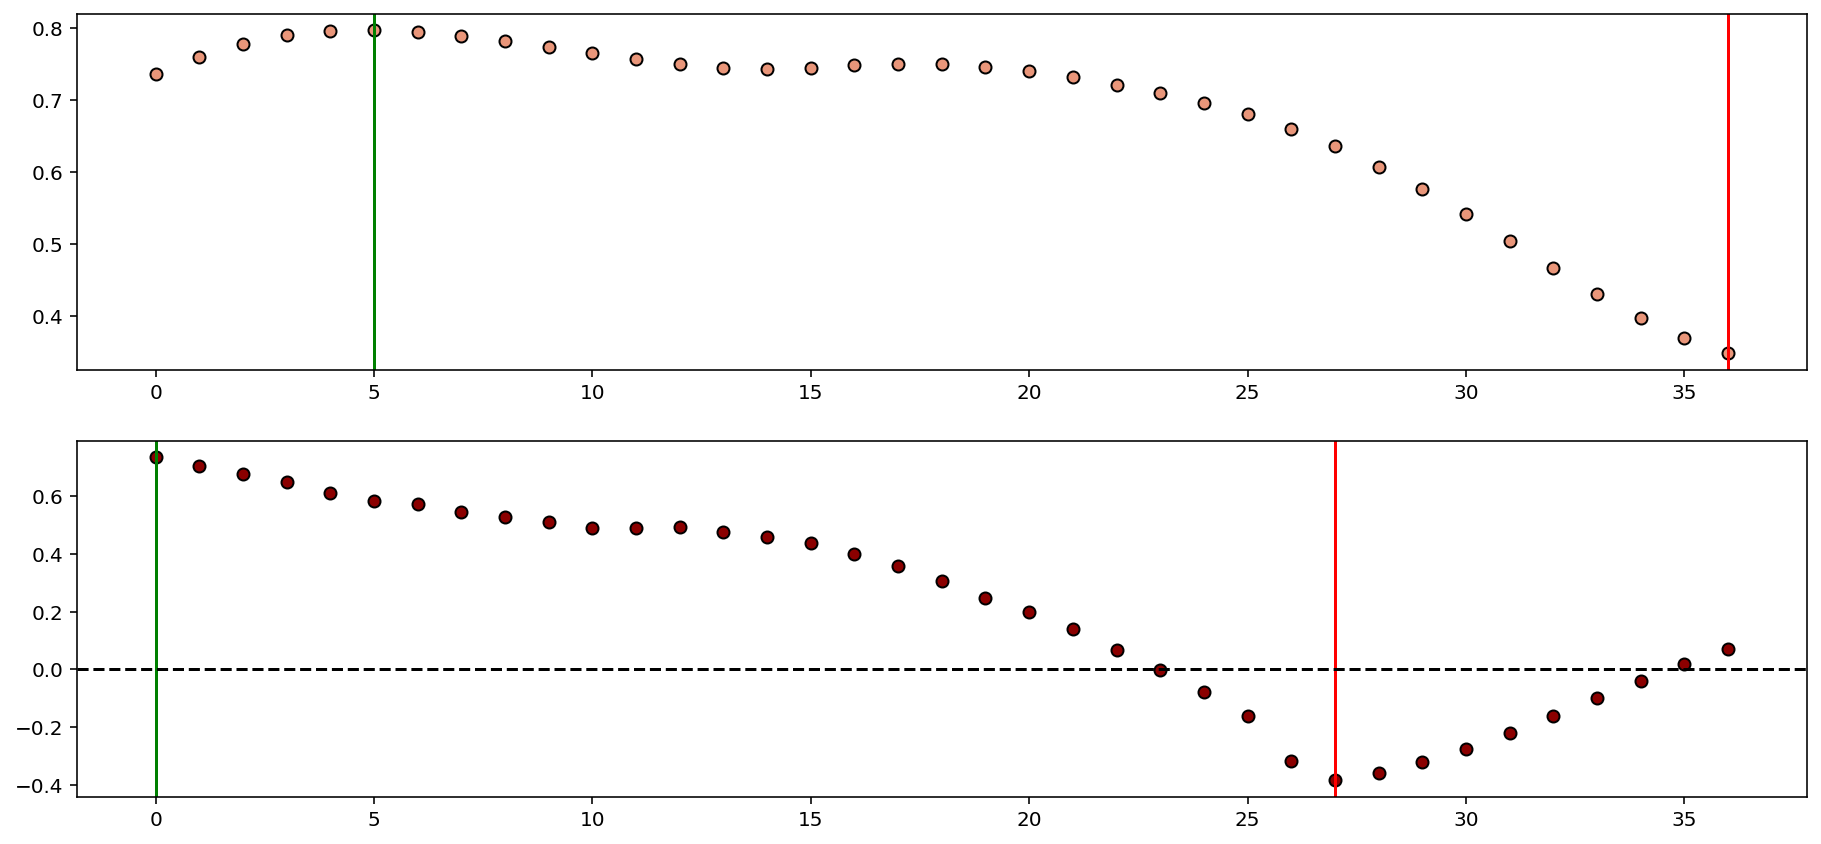

In [136]:
df_all = pd.merge( ppr_bog_df.set_index('date'),  rt_df.set_index("date"), left_index=True, right_index=True)
df_all = df_all[df_all["type"]=="estimate"]
df_all = df_all[["attribute_value2", "median"]]
df_all = df_all.reset_index()

df_all = df_all.set_index("date")
df_all = df_all.loc[pd.to_datetime("2021-01-10"):]
df_all = df_all.reset_index()



fig, ax = plt.subplots(1, 1, figsize=(16.5, 7.2))
ax.scatter(df_all["date"], df_all["attribute_value2"], facecolor='darksalmon', edgecolor='k', s=60, label='PPR')
ax1 = ax.twinx()
ax1.scatter(df_all["date"], df_all["median"], facecolor='purple', edgecolor='k', s=60, label='Rt')
ax1.axhline(y=1, color='k', linestyle='--')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator())

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.tick_params(axis='both', labelsize=15)
ax.set_ylabel('Value', fontsize=15)
ax.legend()

df_all = df_all.set_index('date')
corr_df1 = compute_correlation(df_all["attribute_value2"], df_all["median"], lags = list(range(37) ) )
corr_df2 = compute_correlation(df_all["median"], df_all["attribute_value2"], lags = list(range(37) ) )

fig, ax = plt.subplots(2,1, figsize=(15.5, 7.2))
ax[0].scatter(corr_df1.index.values, corr_df1["value"], edgecolor='k', facecolor='darksalmon')
ax[0].axvline(x=np.argmax(corr_df1["value"]), color='green' )
ax[0].axvline(x=np.argmin(corr_df1["value"]), color='red' )

ax[1].scatter(corr_df2.index.values, corr_df2["value"], edgecolor='k', facecolor='darkred')
ax[1].axvline(x=np.argmax(corr_df2["value"]), color='green' )
ax[1].axvline(x=np.argmin(corr_df2["value"]), color='red' )
ax[1].axhline(y=0, color='k', linestyle='--')
